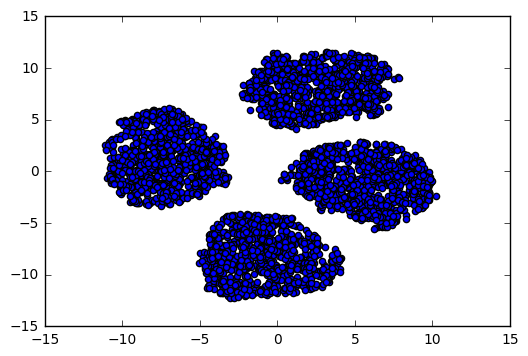

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.manifold import TSNE

dim = 4
params = [(np.random.rand(1,dim) * 100, abs(np.random.random() * 5)) for _ in range(4)]
n = 1000
X = np.ndarray((0,dim))
for mu, sigma in params:
    X = np.append(X, sigma * np.random.randn(n, dim) + mu, axis=0)

# reduce the dimensionality of the data set so we can plot it
model = TSNE(n_components=2, perplexity=80)
reduced = model.fit_transform(X)

plt.scatter(reduced[:,0], reduced[:,1])

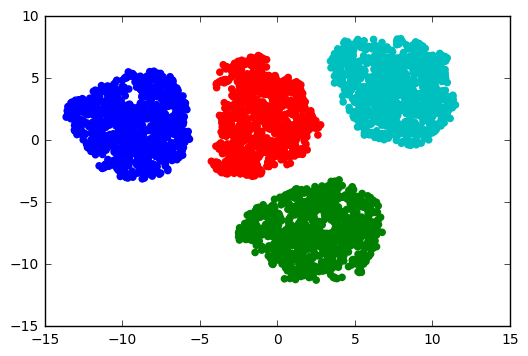

In [27]:
kmeans = cluster.KMeans(len(params))
kmeans.fit(X)
colors = "rgbcyk"
cs = [colors[i % len(colors)] for i in kmeans.labels_]
plt.scatter(reduced[:,0], reduced[:,1], color=cs)

In [ ]:
import math
import sys
import numpy as np
import collections
from collections import Counter, defaultdict
import time 

data_dict = [
	['A', 70, True, 'Class1'],
	['A', 90, True, 'Class2'],
	['A', 85, False, 'Class2'],
	['A', 95, False, 'Class2'],
	['A', 70, False, 'Class1'],
	['B', 90, True, 'Class1'],
	['B', 78, False, 'Class1'],
	['B', 65, True, 'Class1'],
	['B', 75, False, 'Class1'],
	['C', 80, True, 'Class2'],
	['C', 70, True, 'Class2'],
	['C', 80, False, 'Class1'],
	['C', 80, False, 'Class1'],
	['C', 96, False, 'Class1']
]


"""
========================================
calcH: calculates the H for the Entropy
----------------------------------------
-probabilities: an array of the
probabilities of the classifications
========================================
"""
def calcH(probabilities):
	return sum(-p*math.log(p,2) for p in probabilities)


"""
=====================================================================
calcGain: calculates gain of each attributes
---------------------------------------------------------------------
-data: data set that you would like to analyze
-attr_idx: attribute index
-attr_probabilities: the probabilities for the different values of
given attribute
-probabilities:  an array of the probabilities of the classifications
======================================================================
"""
def calcGain(data, attr_idx, attr_probabilities, probabilities):
	H=calcH(probabilities)
	HAttribute=0.0
	denominator=len(data)
	numerators=Counter(d[attr_idx] for d in data)
	for attr, attr_ps in attr_probabilities.items():
		HT=calcH(attr_ps)
		HAttribute=HAttribute + (numerators[attr] / denominator)*HT

	# print("HAttribute: {0}".format(HAttribute))

	gain=H-HAttribute
	# print("gain: {0}".format(gain))
	return gain

"""
===================================================================
getAttrProbabilities: gets the probabilities for a given attribute
-------------------------------------------------------------------
-data: data set that you would like to analyze
-attr_idx: the attribute index you would like to get probabilities for
-class_idx: the class index that you are using to get resulting tree
===================================================================
"""
def getAttrProbabilities(data, attr_idx, class_idx):
	probabilities = defaultdict(list)

	attr_denominators=Counter(d[attr_idx] for d in data)
	class_counts = Counter((d[attr_idx], d[class_idx]) for d in data)
	for data_pair, class_count in class_counts.items():
		attr, classification = data_pair
		probabilities[attr].append(class_count / attr_denominators[attr])
	return probabilities


"""
==============================================================
getClassProbabilities: calculates probabilities for H
--------------------------------------------------------------
-data: data dictionary to look at
-class_idx: the class index that you are using to get resulting tree
===============================================================
"""
def getClassProbabilities(data, class_idx):
	denominator = len(data)
	class_counts = Counter(d[class_idx] for d in data)
	probabilities = [ count / denominator for cls, count in class_counts.items() ]
	return probabilities

"""
==============================================================
partitionNumericalData: partitions numerical data
--------------------------------------------------------------
-data: data dictionary to look at
-attr_idx: attribute index
-class_idx: class index
===============================================================
"""
def partitionNumericalData(data, attr_idx, class_idx):
	avg = sum(d[attr_idx] for d in data) / len(data)
	smaller = []
	bigger = []
	for d in data:
		if d[attr_idx] <= avg:
			smaller.append(d)
		else:
			bigger.append(d)
	return smaller, bigger, avg


"""
==============================================================
getSplittingAttribute: gets the splitting attribute of the
given data set
--------------------------------------------------------------
-data: data dictionary to look at
-attr_types: data dictionary that has the type of each attribute
in the given data set
===============================================================
"""
def getSplittingAttribute(data, attr_types):
	attr_gains=[None] * len(attr_types)

	class_idx = None
	for i, attr_class in enumerate(attr_types):
		if attr_class[1] == "class":
			class_idx = i

	probabilities = getClassProbabilities(data, class_idx)
	for attr_idx, attr_info in enumerate(attr_types):
		attr, attr_type = attr_info
		if attr_type == "categorical":
			attr_probabilities = getAttrProbabilities(data, attr_idx, class_idx)
			attr_gains[attr_idx] = calcGain(data, attr_idx, attr_probabilities, probabilities)
		elif attr_type == "numerical":
			smaller, bigger, median = partitionNumericalData(data, attr_idx, class_idx)
			H_smaller = calcH(getClassProbabilities(smaller, class_idx))
			H_bigger = calcH(getClassProbabilities(bigger, class_idx))
			HTAttribute = (len(smaller) / len(data))*H_smaller + (len(bigger) / len(data))*H_bigger
			H = calcH(probabilities)
			attr_gains[attr_idx] = H - HTAttribute
		else:
			print("WEIRD: {} ATTRIBUTE: {}".format(attr_type, attr))

	max_attr_idx = None
	for i in range(len(attr_gains)):
		if attr_gains[i] is None:
			continue
		if max_attr_idx is None or attr_gains[i] > attr_gains[max_attr_idx]:
			max_attr_idx = i

	print("Splitting Attribute = {0}".format(attr_types[max_attr_idx]))
	return max_attr_idx


"""
==============================================================
getAttrTypes: gets the attrutes and their types
--------------------------------------------------------------
-filePath: the path of the file with the attributes and their
types
==============================================================
"""
def getAttrTypes(filePath):
	attr_types=[]
	with open(filePath, 'r') as fileHandler:
		for line in fileHandler:
			line = line.strip()
			attr=line.split(":")
			attr_types.append([a.strip() for a in attr])
	return attr_types


"""
==============================================================
getDataDict: reads in a data set and turns it into a data
dictionary
--------------------------------------------------------------
-attr_types: the attributes along with what types they are
-filePath: the path of the file with the data set
===============================================================
"""
def getDataDict(attr_types, filePath):
	data=[]
	with open(filePath, 'r') as f:
		for line in f:
			line = line.strip()
			if '?' in line:
				continue

			data_row = []
			for attr_info, elem in zip(attr_types, line.split(",")):
				attr_type = attr_info[1]
				if attr_type == 'numerical':
					data_row.append(float(elem.strip()))
				else:
					data_row.append(elem.strip())
			data.append(data_row)
	return data



"""
==============================================================
createDecsionTree: reads in a data set and turns it into a data
dictionary
--------------------------------------------------------------
-data: data dictionary to look at
-attr_types: the attributes along with what types they are
-parent_name: name of the parent node
-branch_name: name of the branch the parent expands on
===============================================================
"""
node_count = 0
def createDecsionTree(data, attr_types, parent_name, branch_name):
	global node_count
	node_count+=1

	class_idx = None
	for i, attr_info in enumerate(attr_types):
		if attr_info[1] == "class":
			class_idx = i

	active_classes = { datum[class_idx] for datum in data }
	if len(active_classes) > 1 and len(attr_types) > 1:
		split_attr_idx = getSplittingAttribute(data, attr_types)
		split_attr, split_attr_type = attr_types[split_attr_idx]

		node_name = split_attr + '_' + str(node_count)

		if split_attr_type == 'categorical':
			if parent_name is not None:
				print('"{}" -> "{}" [label="{}"];'.format(parent_name, node_name, branch_name), file=sys.stderr)
			print('"{}" [label="{}"];'.format(node_name, split_attr), file=sys.stderr)

			split_attr_nodes = Counter(d[split_attr_idx] for d in data).keys()

			new_dicts={}
			for node in split_attr_nodes:
				new_dicts[node]=[]

			for d in data:
				attr=d[split_attr_idx]
				del d[split_attr_idx]
				new_dicts[attr].append(d)


			attr_types = [a for i, a in enumerate(attr_types) if i != split_attr_idx]
			assert len(data[0]) == len(attr_types)
			#print(data[0])
			#print([t[1] for t in attr_types])
			for node in new_dicts:
				attr_data = new_dicts[node]
				createDecsionTree(attr_data, attr_types, node_name, node)
		else:
			assert split_attr_type == 'numerical', split_attr_type
			smaller, bigger, branching_num = partitionNumericalData(data, split_attr_idx, class_idx)
			if smaller == [] or bigger == []:
				print('We have competing evidence here')
			else:
				if parent_name is not None:
					print('"{}" -> "{}" [label="{}"];'.format(parent_name, node_name, branch_name), file=sys.stderr)
					print('"{}" [label="{}"];'.format(node_name, split_attr), file=sys.stderr)
				createDecsionTree(smaller, attr_types, node_name, "<= " + str(branching_num))
				createDecsionTree(bigger, attr_types, node_name, "> " + str(branching_num))

	else:
		class_name = data[0][class_idx]
		node_name = class_name + '_' + str(node_count)
		print('"{}" [label="{}"];'.format(node_name, class_name), file=sys.stderr)
		print('"{}" -> "{}" [label="{}"];'.format(parent_name, node_name,branch_name), file=sys.stderr)

"""
==============================
			MAIN
==============================
"""
def main():
	start=time.time()
	#attr_types=[["A1","categorical"],["A2","numerical"],["A3","categorical"],["Class","class"]]
	attr_types=getAttrTypes("./large_atters.txt")
	data_dict=getDataDict(attr_types,"./large_dataset.txt")
	
	print("digraph g{", file=sys.stderr)
	createDecsionTree(data_dict,attr_types,None,None)
	print("}", file=sys.stderr)
	print(time.time()-start)




if __name__ == '__main__':
	main()


digraph g{


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['service', 'categorical']


"service_1" [label="service"];
"neptune._2" [label="neptune."];
"service_1" -> "neptune._2" [label="rje"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['num_failed_logins', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['logged_in', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']


"service_1" -> "num_failed_logins_3" [label="telnet"];
"num_failed_logins_3" [label="num_failed_logins"];
"num_failed_logins_3" -> "flag_4" [label="<= 0.30414599007523613"];
"flag_4" [label="flag"];
"flag_4" -> "duration_5" [label="SF"];
"duration_5" [label="duration"];
"duration_5" -> "logged_in_6" [label="<= 5466.769123783032"];
"logged_in_6" [label="logged_in"];
"logged_in_6" -> "src_bytes_7" [label="0"];
"src_bytes_7" [label="src_bytes"];
"mscan._8" [label="mscan."];
"src_bytes_7" -> "mscan._8" [label="<= 24.965870307167236"];
"src_bytes_7" -> "count_9" [label="> 24.965870307167236"];
"count_9" [label="count"];
"count_9" -> "duration_10" [label="<= 80.30434782608695"];
"duration_10" [label="duration"];
"duration_10" -> "src_bytes_11" [label="<= 36.421052631578945"];
"src_bytes_11" [label="src_bytes"];
"normal._12" [label="normal."];
"src_bytes_11" -> "normal._12" [label="<= 102.6"];
"guess_passwd._13" [label="guess_passwd."];
"src_bytes_11" -> "guess_passwd._13" [label="> 102.6"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['num_file_creations', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_srv_rerror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['is_guest_login', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['root_shell', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['num_root', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_srv_rerror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_diff_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_diff_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_by

"logged_in_6" -> "src_bytes_16" [label="1"];
"src_bytes_16" [label="src_bytes"];
"src_bytes_16" -> "num_file_creations_17" [label="<= 1159.615"];
"num_file_creations_17" [label="num_file_creations"];
"num_file_creations_17" -> "dst_host_srv_rerror_rate_18" [label="<= 0.3510971786833856"];
"dst_host_srv_rerror_rate_18" [label="dst_host_srv_rerror_rate"];
"dst_host_srv_rerror_rate_18" -> "is_guest_login_19" [label="<= 0.10268382352941173"];
"is_guest_login_19" [label="is_guest_login"];
"is_guest_login_19" -> "root_shell_20" [label="0"];
"root_shell_20" [label="root_shell"];
"root_shell_20" -> "num_root_21" [label="<= 0.10047846889952153"];
"num_root_21" [label="num_root"];
"num_root_21" -> "dst_host_srv_rerror_rate_22" [label="<= 0.19148936170212766"];
"dst_host_srv_rerror_rate_22" [label="dst_host_srv_rerror_rate"];
"dst_host_srv_rerror_rate_22" -> "dst_host_diff_srv_rate_23" [label="<= 0.0041666666666666675"];
"dst_host_diff_srv_rate_23" [label="dst_host_diff_srv_rate"];
"normal._24" [

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['srv_diff_host_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['num_failed_logins', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['num_failed_logins', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['hot', 'numerical']
WEIRD: class ATTRIBUTE: Class
Spli

"num_failed_logins_3" -> "src_bytes_107" [label="> 0.30414599007523613"];
"src_bytes_107" [label="src_bytes"];
"src_bytes_107" -> "duration_108" [label="<= 139.9554003224073"];
"duration_108" [label="duration"];
"guess_passwd._109" [label="guess_passwd."];
"duration_108" -> "guess_passwd._109" [label="<= 0.6548720740337507"];
"duration_108" -> "num_failed_logins_110" [label="> 0.6548720740337507"];
"num_failed_logins_110" [label="num_failed_logins"];
"num_failed_logins_110" -> "dst_bytes_111" [label="<= 1.0379746835443038"];
"dst_bytes_111" [label="dst_bytes"];
"guess_passwd._112" [label="guess_passwd."];
"dst_bytes_111" -> "guess_passwd._112" [label="<= 178.25"];
"dst_bytes_111" -> "flag_113" [label="> 178.25"];
"flag_113" [label="flag"];
"normal._114" [label="normal."];
"flag_113" -> "normal._114" [label="SF"];
"guess_passwd._115" [label="guess_passwd."];
"flag_113" -> "guess_passwd._115" [label="S3"];
"xlock._116" [label="xlock."];
"num_failed_logins_110" -> "xlock._116" [label="> 1

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_srv_count', 'numerical']


"service_1" -> "dst_host_srv_count_141" [label="smtp"];
"dst_host_srv_count_141" [label="dst_host_srv_count"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_rerror_rate', 'numerical']


"dst_host_srv_count_141" -> "dst_host_rerror_rate_142" [label="<= 194.45068514977692"];
"dst_host_rerror_rate_142" [label="dst_host_rerror_rate"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']


"dst_host_rerror_rate_142" -> "flag_143" [label="<= 0.0646344634463433"];
"flag_143" [label="flag"];
"neptune._144" [label="neptune."];
"flag_143" -> "neptune._144" [label="S0"];
"normal._145" [label="normal."];
"flag_143" -> "normal._145" [label="REJ"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['num_root', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['rerror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_diff_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']


"flag_143" -> "num_root_146" [label="SF"];
"num_root_146" [label="num_root"];
"normal._147" [label="normal."];
"num_root_146" -> "normal._147" [label="<= 0.0049813200498132005"];
"num_root_146" -> "src_bytes_148" [label="> 0.0049813200498132005"];
"src_bytes_148" [label="src_bytes"];
"normal._149" [label="normal."];
"src_bytes_148" -> "normal._149" [label="<= 2994.4736842105262"];
"sendmail._150" [label="sendmail."];
"src_bytes_148" -> "sendmail._150" [label="> 2994.4736842105262"];
"normal._151" [label="normal."];
"flag_143" -> "normal._151" [label="S2"];
"dst_host_rerror_rate_142" -> "src_bytes_152" [label="> 0.0646344634463433"];
"src_bytes_152" [label="src_bytes"];
"src_bytes_152" -> "flag_153" [label="<= 2189.549481621112"];
"flag_153" [label="flag"];
"flag_153" -> "rerror_rate_154" [label="SF"];
"rerror_rate_154" [label="rerror_rate"];
"normal._155" [label="normal."];
"rerror_rate_154" -> "normal._155" [label="<= 0.002697841726618705"];
"saint._156" [label="saint."];
"rerror_rate

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_count', 'numerical']


"dst_host_srv_count_141" -> "dst_host_count_166" [label="> 194.45068514977692"];
"dst_host_count_166" [label="dst_host_count"];
"normal._167" [label="normal."];
"dst_host_count_166" -> "normal._167" [label="<= 248.119364448858"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']


"dst_host_count_166" -> "src_bytes_168" [label="> 248.119364448858"];
"src_bytes_168" [label="src_bytes"];
"normal._169" [label="normal."];
"src_bytes_168" -> "normal._169" [label="<= 2597.176287375415"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_diff_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['diff_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_same_src_port_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class

"src_bytes_168" -> "src_bytes_170" [label="> 2597.176287375415"];
"src_bytes_170" [label="src_bytes"];
"mailbomb._171" [label="mailbomb."];
"src_bytes_170" -> "mailbomb._171" [label="<= 2599.1179284525792"];
"normal._172" [label="normal."];
"src_bytes_170" -> "normal._172" [label="> 2599.1179284525792"];
"neptune._173" [label="neptune."];
"service_1" -> "neptune._173" [label="netbios_ns"];
"neptune._174" [label="neptune."];
"service_1" -> "neptune._174" [label="discard"];
"normal._175" [label="normal."];
"service_1" -> "normal._175" [label="icmp"];
"service_1" -> "flag_176" [label="link"];
"flag_176" [label="flag"];
"neptune._177" [label="neptune."];
"flag_176" -> "neptune._177" [label="S0"];
"flag_176" -> "dst_host_diff_srv_rate_178" [label="REJ"];
"dst_host_diff_srv_rate_178" [label="dst_host_diff_srv_rate"];
"neptune._179" [label="neptune."];
"dst_host_diff_srv_rate_178" -> "neptune._179" [label="<= 0.08880952380952392"];
"satan._180" [label="satan."];
"dst_host_diff_srv_rate_178" -

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['srv_count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['srv_count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_diff_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['same_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']


"srv_count_229" -> "src_bytes_230" [label="<= 17.48854961832061"];
"src_bytes_230" [label="src_bytes"];
"ipsweep._231" [label="ipsweep."];
"src_bytes_230" -> "ipsweep._231" [label="<= 18.032715376226825"];
"src_bytes_230" -> "srv_count_232" [label="> 18.032715376226825"];
"srv_count_232" [label="srv_count"];
"normal._233" [label="normal."];
"srv_count_232" -> "normal._233" [label="<= 2.3846153846153846"];
"saint._234" [label="saint."];
"srv_count_232" -> "saint._234" [label="> 2.3846153846153846"];
"srv_count_229" -> "src_bytes_235" [label="> 17.48854961832061"];
"src_bytes_235" [label="src_bytes"];
"ipsweep._236" [label="ipsweep."];
"src_bytes_235" -> "ipsweep._236" [label="<= 16.977099236641223"];
"saint._237" [label="saint."];
"src_bytes_235" -> "saint._237" [label="> 16.977099236641223"];
"dst_host_count_228" -> "count_238" [label="> 59.481159420289856"];
"count_238" [label="count"];
"normal._239" [label="normal."];
"count_238" -> "normal._239" [label="<= 6.604819277108434"];
"sain

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_srv_rerror_rate', 'numerical']


"service_1" -> "dst_host_srv_rerror_rate_266" [label="http"];
"dst_host_srv_rerror_rate_266" [label="dst_host_srv_rerror_rate"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['num_compromised', 'numerical']


"dst_host_srv_rerror_rate_266" -> "num_compromised_267" [label="<= 0.012138523958227362"];
"num_compromised_267" [label="num_compromised"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']


"num_compromised_267" -> "flag_268" [label="<= 0.0032154077758868964"];
"flag_268" [label="flag"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['root_shell', 'numerical']


"flag_268" -> "root_shell_269" [label="SF"];
"root_shell_269" [label="root_shell"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_same_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']


"root_shell_269" -> "dst_host_same_srv_rate_270" [label="<= 0.0004849700387154048"];
"dst_host_same_srv_rate_270" [label="dst_host_same_srv_rate"];
"dst_host_same_srv_rate_270" -> "src_bytes_271" [label="<= 0.9957910491948847"];
"src_bytes_271" [label="src_bytes"];
"src_bytes_271" -> "src_bytes_272" [label="<= 272.60211800302574"];
"src_bytes_272" [label="src_bytes"];
"src_bytes_272" -> "src_bytes_273" [label="<= 233.10781990521326"];
"src_bytes_273" [label="src_bytes"];


WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['num_access_files', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']


"src_bytes_273" -> "src_bytes_274" [label="<= 211.04246575342466"];
"src_bytes_274" [label="src_bytes"];
"src_bytes_274" -> "src_bytes_275" [label="<= 184.78827361563518"];
"src_bytes_275" [label="src_bytes"];
"src_bytes_275" -> "src_bytes_276" [label="<= 176.9855072463768"];
"src_bytes_276" [label="src_bytes"];
"apache2._277" [label="apache2."];
"src_bytes_276" -> "apache2._277" [label="<= 152.89473684210526"];
"normal._278" [label="normal."];
"src_bytes_276" -> "normal._278" [label="> 152.89473684210526"];
"normal._279" [label="normal."];
"src_bytes_275" -> "normal._279" [label="> 176.9855072463768"];
"normal._280" [label="normal."];
"src_bytes_274" -> "normal._280" [label="> 184.78827361563518"];
"normal._281" [label="normal."];
"src_bytes_273" -> "normal._281" [label="> 211.04246575342466"];
"normal._282" [label="normal."];
"src_bytes_272" -> "normal._282" [label="> 233.10781990521326"];
"normal._283" [label="normal."];
"src_bytes_271" -> "normal._283" [label="> 272.60211800302574"

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['rerror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['logged_in', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['same_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_diff_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_srv_serror_rate', 'numerical']
WEIRD: class ATTRIBU

"flag_302" -> "src_bytes_303" [label="SF"];
"src_bytes_303" [label="src_bytes"];
"src_bytes_303" -> "rerror_rate_304" [label="<= 50239.841584158414"];
"rerror_rate_304" [label="rerror_rate"];
"rerror_rate_304" -> "duration_305" [label="<= 0.025"];
"duration_305" [label="duration"];
"normal._306" [label="normal."];
"duration_305" -> "normal._306" [label="<= 1.9525862068965518"];
"duration_305" -> "duration_307" [label="> 1.9525862068965518"];
"duration_307" [label="duration"];
"apache2._308" [label="apache2."];
"duration_307" -> "apache2._308" [label="<= 75.5"];
"normal._309" [label="normal."];
"duration_307" -> "normal._309" [label="> 75.5"];
"apache2._310" [label="apache2."];
"rerror_rate_304" -> "apache2._310" [label="> 0.025"];
"back._311" [label="back."];
"src_bytes_303" -> "back._311" [label="> 50239.841584158414"];
"back._312" [label="back."];
"flag_302" -> "back._312" [label="S2"];
"flag_302" -> "dst_bytes_313" [label="RSTR"];
"dst_bytes_313" [label="dst_bytes"];
"dst_bytes_313"

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['land', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['srv_count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_srv_count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['logged_in', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['is_guest_login', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting At

"service_1" -> "duration_361" [label="ftp"];
"duration_361" [label="duration"];
"duration_361" -> "logged_in_362" [label="<= 247.07375099127677"];
"logged_in_362" [label="logged_in"];
"logged_in_362" -> "flag_363" [label="0"];
"flag_363" [label="flag"];
"neptune._364" [label="neptune."];
"flag_363" -> "neptune._364" [label="S0"];
"neptune._365" [label="neptune."];
"flag_363" -> "neptune._365" [label="RSTO"];
"saint._366" [label="saint."];
"flag_363" -> "saint._366" [label="REJ"];
"flag_363" -> "duration_367" [label="SF"];
"duration_367" [label="duration"];
"guess_passwd._368" [label="guess_passwd."];
"duration_367" -> "guess_passwd._368" [label="<= 0.0784313725490196"];
"duration_367" -> "dst_host_count_369" [label="> 0.0784313725490196"];
"dst_host_count_369" [label="dst_host_count"];
"guess_passwd._370" [label="guess_passwd."];
"dst_host_count_369" -> "guess_passwd._370" [label="<= 127.0"];
"dst_host_count_369" -> "duration_371" [label="> 127.0"];
"duration_371" [label="duration"];
"

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['num_file_creations', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['diff_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['diff_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['protocol_type', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['src_bytes', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_same_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_same_src_port_rate', 'numerical']
WEIRD:

"service_1" -> "diff_srv_rate_418" [label="other"];
"diff_srv_rate_418" [label="diff_srv_rate"];
"diff_srv_rate_418" -> "flag_419" [label="<= 0.8549851966727771"];
"flag_419" [label="flag"];
"neptune._420" [label="neptune."];
"flag_419" -> "neptune._420" [label="S0"];
"neptune._421" [label="neptune."];
"flag_419" -> "neptune._421" [label="RSTO"];
"httptunnel._422" [label="httptunnel."];
"flag_419" -> "httptunnel._422" [label="REJ"];
"flag_419" -> "protocol_type_423" [label="SF"];
"protocol_type_423" [label="protocol_type"];
"protocol_type_423" -> "src_bytes_424" [label="udp"];
"src_bytes_424" [label="src_bytes"];
"src_bytes_424" -> "src_bytes_425" [label="<= 112.82885906040268"];
"src_bytes_425" [label="src_bytes"];
"src_bytes_425" -> "dst_host_same_srv_rate_426" [label="<= 4.394736842105263"];
"dst_host_same_srv_rate_426" [label="dst_host_same_srv_rate"];
"satan._427" [label="satan."];
"dst_host_same_srv_rate_426" -> "satan._427" [label="<= 0.007500000000000004"];
"dst_host_same_srv_r

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['rerror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_same_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['same_srv_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_diff_srv_rate', 'numerical']


"diff_srv_rate_418" -> "rerror_rate_497" [label="> 0.8549851966727771"];
"rerror_rate_497" [label="rerror_rate"];
"rerror_rate_497" -> "dst_host_same_srv_rate_498" [label="<= 0.8432428355957509"];
"dst_host_same_srv_rate_498" [label="dst_host_same_srv_rate"];
"dst_host_same_srv_rate_498" -> "flag_499" [label="<= 0.0028338762214983717"];
"flag_499" [label="flag"];
"satan._500" [label="satan."];
"flag_499" -> "satan._500" [label="SF"];
"flag_499" -> "same_srv_rate_501" [label="REJ"];
"same_srv_rate_501" [label="same_srv_rate"];
"satan._502" [label="satan."];
"same_srv_rate_501" -> "satan._502" [label="<= 0.006666666666666667"];
"httptunnel._503" [label="httptunnel."];
"same_srv_rate_501" -> "httptunnel._503" [label="> 0.006666666666666667"];
"satan._504" [label="satan."];
"flag_499" -> "satan._504" [label="S0"];
"portsweep._505" [label="portsweep."];
"flag_499" -> "portsweep._505" [label="RSTR"];
"dst_host_same_srv_rate_498" -> "flag_506" [label="> 0.0028338762214983717"];
"flag_506" [la

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['rerror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_rerror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
We have competing evidence here
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
W

"dst_host_diff_srv_rate_509" -> "rerror_rate_511" [label="> 0.9943876337693169"];
"rerror_rate_511" [label="rerror_rate"];
"rerror_rate_511" -> "serror_rate_512" [label="<= 0.9524278215222834"];
"serror_rate_512" [label="serror_rate"];
"serror_rate_512" -> "serror_rate_513" [label="<= 0.06568686488520963"];
"serror_rate_513" [label="serror_rate"];
"serror_rate_513" -> "dst_host_serror_rate_514" [label="<= 0.05236352357320047"];
"dst_host_serror_rate_514" [label="dst_host_serror_rate"];
"dst_host_serror_rate_514" -> "dst_host_rerror_rate_515" [label="<= 0.04841181902123695"];
"dst_host_rerror_rate_515" [label="dst_host_rerror_rate"];
"saint._516" [label="saint."];
"dst_host_rerror_rate_515" -> "saint._516" [label="<= 0.9618932038834931"];
"dst_host_rerror_rate_515" -> "dst_host_serror_rate_517" [label="> 0.9618932038834931"];
"dst_host_serror_rate_517" [label="dst_host_serror_rate"];
"satan._518" [label="satan."];
"dst_host_serror_rate_517" -> "satan._518" [label="<= 0.02706521739130433

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting

"serror_rate_513" -> "dst_host_serror_rate_547" [label="> 0.05236352357320047"];
"dst_host_serror_rate_547" [label="dst_host_serror_rate"];
"dst_host_serror_rate_547" -> "count_548" [label="<= 0.0640642722117202"];
"count_548" [label="count"];
"saint._549" [label="saint."];
"count_548" -> "saint._549" [label="<= 472.2314285714286"];
"count_548" -> "flag_550" [label="> 472.2314285714286"];
"flag_550" [label="flag"];
"satan._551" [label="satan."];
"flag_550" -> "satan._551" [label="S0"];
"flag_550" -> "count_552" [label="REJ"];
"count_552" [label="count"];
"count_552" -> "count_553" [label="<= 495.7826086956522"];
"count_553" [label="count"];
"count_553" -> "count_554" [label="<= 486.0487804878049"];
"count_554" [label="count"];
"satan._555" [label="satan."];
"count_554" -> "satan._555" [label="<= 481.5593220338983"];
"saint._556" [label="saint."];
"count_554" -> "saint._556" [label="> 481.5593220338983"];
"saint._557" [label="saint."];
"count_553" -> "saint._557" [label="> 486.048780487

WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['rerror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['flag', 'categorical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_rate', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['duration', 'numerical']
We have competing evidence here
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['count', 'numerical']
WEIRD: class ATTRIBUTE: Class
Splitting Attribute = ['dst_host_serror_ra

"dst_host_serror_rate_635" -> "dst_host_serror_rate_636" [label="<= 0.019707571801566567"];
"dst_host_serror_rate_636" [label="dst_host_serror_rate"];
"satan._637" [label="satan."];
"dst_host_serror_rate_636" -> "satan._637" [label="<= 0.00014842300556586272"];
"dst_host_serror_rate_636" -> "flag_638" [label="> 0.00014842300556586272"];
"flag_638" [label="flag"];
"satan._639" [label="satan."];
"flag_638" -> "satan._639" [label="S0"];
"flag_638" -> "count_640" [label="REJ"];
"count_640" [label="count"];
"satan._641" [label="satan."];
"count_640" -> "satan._641" [label="<= 503.57142857142856"];
"saint._642" [label="saint."];
"count_640" -> "saint._642" [label="> 503.57142857142856"];
"dst_host_serror_rate_635" -> "rerror_rate_643" [label="> 0.019707571801566567"];
"rerror_rate_643" [label="rerror_rate"];
"rerror_rate_643" -> "dst_host_serror_rate_644" [label="<= 0.9655316606929613"];
"dst_host_serror_rate_644" [label="dst_host_serror_rate"];
"dst_host_serror_rate_644" -> "dst_host_serror